# Hands-on Machine Learning

## Session 7: Deep Learning

by Daniel Bug

### Goal of this session

In this session you will:
* implement a deep neural network
* learn about different layer types and activation functions
* experiment with visualization techniques

Mind that there are still a few things we hide behind the scenes:
* Data Loading / Handling is done using framework utilities (see additional python scripts and pytorch doc)
* Data Augmentation will be covered in a later session

### Dataset

This session uses the PascalVOC dataset, which is accessible on this server.
The dataset comprises input images that can be classified with different strategies.
We consider an image classification problem, i.e. decide which objects from a finite set of classes appear in the input image.
Since multiple objects may appear in each image, this is a multi-label classification task.

Let's dive right into the task:
Make sure to run the imports and continue loading the dataset to RAM.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'  # Set this parameter to YOUR GROUP NUMBER

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import voc as dsetVOC
import torchvision.transforms as standard_transforms
import transforms as extended_transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch  import optim

#### Loading the dataset

We prepared a loader for you that can automatically grab a training- and testset.
Run the cell below a few times to get an overview of the data available.

You can print the cls2lbl dictionary to see the list of all classes.


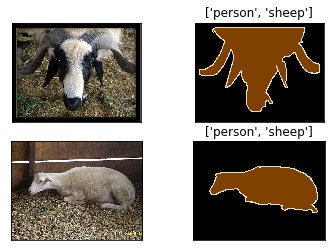

In [2]:
train_set = dsetVOC.VOC('train')
valid_set = dsetVOC.VOC('valid')
cls2lbl = dsetVOC.class_to_label

for i in range(2):
    img, mask, classes = valid_set.__getitem__(np.random.randint(0, 100 + 1), colorize=True)
    plt.subplot(2,2,2*i+1)
    plt.imshow(img)
    plt.xticks(()); plt.yticks(())
    plt.subplot(2,2,2*i+2)
    plt.imshow(mask)
    plt.xticks(()); plt.yticks(())
    plt.title(str([cls2lbl[x+1] for x in np.where(classes>0.)[0]]))
plt.show()

## Building a network

### Defining functional units

As introduced in the preparation, we are going to implement a VGGNet model as a classifier.
From the previous session you know the setup of classical Multilayer Perceptrons.

**Q1a:** Which other layer types appear in the VGG architecture?

Convolutional , Relu, Maxpool, FC

**Q1b:** How can a VGG net be structured in small functional units (3-4 layers)?



#### ... write your answers/ideas in this box

The blocks of the VGGNet should look like this:
![Blockstructure](vgg16block-structure.png "Blockstructure")
Note that this structure is a little bit different from the original architecture. and reflects some recent advances in Deep Learning

**TASK** Implement the function below:

*Hint:* implement a functional block by defining a new python class which inherits from nn.Module (see pytorch doc).
You have to write an *init* and *forward* method. 

In [3]:
class VGGBlock(nn.Module):
    def __init__(self, ifeat, ofeat, N=2):
        super(VGGBlock, self).__init__()
        assert(N in (2, 3))
        
        '''
        self.N=N
        # setup all layers inside a VGG block here
        self.conv1 = nn.Conv2d(ifeat, ofeat,kernel_size=3, padding=0)
        
        self.conv2 = nn.Conv2d(ofeat, ofeat,kernel_size=3, padding=0)
        
        self.conv3 = nn.Conv2d(ofeat, ofeat,kernel_size=1, padding=0)
        self.bnl1 = nn.BatchNorm2d(ofeat)
        self.bnl2 = nn.BatchNorm2d(ofeat)
        self.bnl3 = nn.BatchNorm2d(ofeat)
        self.maxpool = nn.MaxPool2d((3,3), stride=2)
        '''
        
        self.N = N
        self.conv1 = nn.Conv2d(ifeat, ofeat, 3, padding=0)
        self.conv2 = nn.Conv2d(ofeat, ofeat, 3, padding=0)
        self.bn1 = nn.BatchNorm2d(ofeat)
        self.bn2 = nn.BatchNorm2d(ofeat)
        self.maxpool = nn.MaxPool2d((3, 3), stride=2)
        if 3==N:
            self.conv3 = nn.Conv2d(ofeat, ofeat, 1, padding=0)
            self.bn3 = nn.BatchNorm2d(ofeat)
        

    def forward(self, x):
        # define the forward method,  note that there are 2 or 3 convolution layers
        '''
        if self.N==2:
            x = F.relu(self.bnl1(self.conv1(x)))
            x = F.relu(self.bnl2(self.conv2(x)))
            x = self.maxpool(x)
            #print(x.shape)
            return x
        elif self.N==3:
            x = F.relu(self.bnl1(self.conv1(x)))
            x = F.relu(self.bnl2(self.conv2(x)))
            x = F.relu(self.bnl3(self.conv3(x)))
            x = self.maxpool(x)
            return x
        return x
        '''
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        if self.N==3:
            x = self.conv3(x)
            x = self.bn3(x)
            x = F.relu(x)
        x = self.maxpool(x)
        return x

### Main Architecture

The standard VGG Net is used to predict a single class. Recall that in PascalVOC multiple objects may be present in an image.

**Q2:** What changes between a single and multi-label scenario?

#### ... write your answers/ideas in this box

Since the number of classes in PascalVOC is much smaller than in the ILSCVR Challenge (where VGG16 was benchmarked) the number of parameters for the Linear Layers can drastically be reduced in this session. Use _1024_ instead of _4096_ parameters.

**TASK** Using the block diagram in the preparation and your pytorch module above, implement a VGG-16 network as nn.Module.

In [4]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        # set up the blocks for the feature extractor part
        self.block1 = VGGBlock(3, 64, N=2)
        self.block2 = VGGBlock(64, 128,N=2)
        self.block3 = VGGBlock(128, 256, N=3)
        self.block4 = VGGBlock(256,512, N=3)
        self.block5 = VGGBlock(512,512, N=3)
        
        k = 5
        
        self.FC1=nn.Linear(512*k*k,1024)
        self.DO1=nn.Dropout(p=0.5, inplace = True)
        self.FC2=nn.Linear(1024,1024)
        self.DO2=nn.Dropout(p=0.1, inplace = True)
        self.FC3=nn.Linear(1024,20)
        
        # set up the dense layers here, this is the classifier part of the network
        # don't forget the Dropout for a better learning behaviour
        # ... your part

    def forward(self, x):
        # implement the forward function
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        
        
        
        #print(x.shape)  # useful for finding the 'k' above
        x = x.view(x.size(0), -1)  # this call of view transforms the 2D feature field into a vector
        # implement the classifier function
        x=F.relu(self.DO1(self.FC1(x)))
        x=F.relu(self.DO2(self.FC2(x)))
        x=F.relu(self.FC3(x))
        
        return x

In [5]:
512*25

12800

### Data Preparation

This part covers necessary preparations to use the images from PascalVOC in the training process.
Read through the implementations below and using the pytorch doc explore what is done here.

In [6]:
def get_data_loaders():
    mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    inp_transform = standard_transforms.Compose([
        standard_transforms.Pad(300),
        standard_transforms.CenterCrop(500),
        standard_transforms.Resize(320),
        standard_transforms.RandomHorizontalFlip(),  # We can include this here, since we don't use the masks anyways.
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])

    tgt_transform = standard_transforms.Compose([
        standard_transforms.Pad(300),
        standard_transforms.CenterCrop(500),
        standard_transforms.Resize(320),
        standard_transforms.ToTensor()])

    train_set = dsetVOC.VOC('train', transform=inp_transform, target_transform=tgt_transform)
    valid_set = dsetVOC.VOC('valid', transform=inp_transform, target_transform=tgt_transform)

    train_loader = DataLoader(train_set, batch_size=16, num_workers=4, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=1, num_workers=4, shuffle=False)
    
    return train_loader, valid_loader

## Training Loop

**Q3:** How is the training process structured? Which steps form an epoch?

#### ... write your answers/ideas in this box

**TASK** Implement a training loop for the VGG16 model.
In PyTorch you need to set up model, loss function and optimizer. This is done as initialization before entering the loop.
During trainig we iterate multiple times through the dataset until the loss is not reduced any further.
Iteration in mini-batches is necessary since using the entire dataset at once would largely exceed the GPUs memory capacity.

For an improved estimation of the actual performance we iterate over the validation data as well (*Recap* session on unbiased evaluation).

In [7]:
network = VGG16()

network.cuda()

# initialize your loss criterion
#ost_func = nn.BCEwithLogitsloss() 
criterion = torch.nn.BCEWithLogitsLoss()


# initialize an optimizer object
optimizer= optim.SGD(network.parameters(),lr=0.001,  weight_decay=1e-7)

train_loader, valid_loader = get_data_loaders()

for epoch in range(11):
    
    network.train(True)
    ep_train_losses = []
    for batch_nr, data in enumerate(train_loader):
        # get the required data and labels and wrap them in variables for the GPU processing
        '''
        img, mask, classes =data
        input_images =Variable(img).cuda()
        labels = Variable(classes).cuda()
        
        output = network(input_images)
        
        loss =cost_func(output,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_train_losses.append(loss)
        '''
        
        
        imgs, _, lbls = data
        inputs = Variable(imgs).cuda()
        labels = Variable(lbls).cuda()
        
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
# zero old gradient values
# compute new gradients
# update weights
        ep_train_losses.append(loss.cpu().data.numpy())
        if batch_nr % 10 == 0:
            print('\r{} mean {:.5f}'.format(batch_nr, 100*np.mean(ep_train_losses)))
        #print(loss.cpu().data.numpy())
        
        # ...
        
        # (optional) write some visualization to check if it works
        # ...
        
        # compute a loss from the network output
        # ...
        
        # ...  # zero old gradient values
        
        # ...  # compute new gradients
        # ...  # update weights
        
        # write some updating output for the current loss
        # print("batch_number",batch_nr,"loss",ep_train_losses(batch_nr))
        # ...

    
    network.train(False)
    ep_valid_losses = []
    for batch_nr, data in enumerate(valid_loader):
        # repeat the steps above for the validation set
        # which steps have to be skipped?
        '''
        
        img, mask, classes =data
        input_images =Variable(img).cuda()
        labels = Variable(classes).cuda()
        
        output = network(input_images)
        
        loss =cost_func(output,labels)
    
        ep_train_losses.append(loss)
        '''
        imgs, _, lbls = data
        inputs = Variable(imgs).cuda()
        labels = Variable(lbls).cuda()
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        ep_valid_losses.append(loss.cpu().data.numpy())
    print('\rValidation {} mean {:.5f} std {:.5f}'.format(epoch, 100*np.mean(ep_valid_losses), 100*np.std(ep_valid_losses)))

    #torch.save(network, './model_ep{:02d}_adam.pth'.format(epoch))
torch.save(network, './model_ep{:02d}_adam.pth'.format(epoch))

# save your trained model
# ...



0 mean 71.29960
10 mean 71.03553
20 mean 70.93263
30 mean 70.83833
40 mean 70.71649
50 mean 70.63509
60 mean 70.54645
70 mean 70.47180
80 mean 70.40493
90 mean 70.34268
100 mean 70.28902
110 mean 70.24473
120 mean 70.20467
130 mean 70.16270
140 mean 70.12650
150 mean 70.09365
160 mean 70.06394
170 mean 70.03664
180 mean 70.00948
190 mean 69.98473
200 mean 69.96211
210 mean 69.94058
220 mean 69.92265
230 mean 69.90364
240 mean 69.88649
250 mean 69.87066
260 mean 69.85623
270 mean 69.84188
280 mean 69.82876
290 mean 69.81640
300 mean 69.80423
310 mean 69.79216
320 mean 69.78123
330 mean 69.77056
340 mean 69.76030
350 mean 69.75130
360 mean 69.74192
370 mean 69.73390
380 mean 69.72556
390 mean 69.71756
400 mean 69.71006
410 mean 69.70325
420 mean 69.69664
430 mean 69.68972
440 mean 69.68328
450 mean 69.67689
460 mean 69.67053
470 mean 69.66494
480 mean 69.65932
490 mean 69.65412
500 mean 69.64886
510 mean 69.64349
520 mean 69.63822
530 mean 69.63317
Validation 0 mean 69.31025 std 0.01611


120 mean 69.32105
130 mean 69.32104
140 mean 69.32096
150 mean 69.32089
160 mean 69.32086
170 mean 69.32065
180 mean 69.32065
190 mean 69.32065
200 mean 69.32076
210 mean 69.32057
220 mean 69.32059
230 mean 69.32060
240 mean 69.32053
250 mean 69.32065
260 mean 69.32055
270 mean 69.32060
280 mean 69.32065
290 mean 69.32056
300 mean 69.32042
310 mean 69.32043
320 mean 69.32039
330 mean 69.32024
340 mean 69.32031
350 mean 69.32029
360 mean 69.32041
370 mean 69.32044
380 mean 69.32049
390 mean 69.32042
400 mean 69.32044
410 mean 69.32049
420 mean 69.32047
430 mean 69.32045
440 mean 69.32039
450 mean 69.32033
460 mean 69.32037
470 mean 69.32032
480 mean 69.32034
490 mean 69.32031
500 mean 69.32029
510 mean 69.32024
520 mean 69.32029
530 mean 69.32026
Validation 8 mean 69.31472 std 0.00001
0 mean 69.32043
10 mean 69.32103
20 mean 69.32047
30 mean 69.32054
40 mean 69.32029
50 mean 69.31957
60 mean 69.31964
70 mean 69.31944
80 mean 69.31940
90 mean 69.31922
100 mean 69.31913
110 mean 69.31869


/usr/local/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type VGG16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type VGGBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Visualize some examples

Verification is important! To assess the quality of the model we have to find suitable measures to quantify the results for our test and validation data (ideally in a way we can easily understand), but more often than not, it will help tremendously to simply browse through some examples and verify the model by manual inspection.

In [8]:
network = torch.load('./model_ep10_adam.pth')
network.train(False)

_, browse_loader = get_data_loaders()
cls2lbl = dsetVOC.class_to_label

num_labels = 1e-12
top_5_scores = []
top_1_scores = []
myscore = [ [] for i in range(5) ]
for img_nr, data in enumerate(browse_loader):
    imgs, _, lbls = data

    inputs = Variable(imgs).cuda()
    output = torch.sigmoid(network(inputs))
    prediction = np.squeeze(output.cpu().data.numpy())
    args = np.argsort(prediction)
    top5 = np.argsort(prediction)[-5:]
    top1 = np.argsort(prediction)[-1]
    
    labels = lbls.numpy()[0]
        
    # implementation top5 error
    top_5_score = 0
    for ll in np.where(labels>0)[0]:
        if ll in top5:
            top_5_score += 1
    top_5_score = top_5_score/np.sum(labels)
    top_5_scores.append(top_5_score)
    
    # Implement your on error measure
    # ...
    num_labels = np.sum(labels)
    top_predicted = np.argsort(prediction)[-num_labels:]
    if np.in1d(top_predicted, np.where(labels==1)).all():
        top_1_scores.append(1)
    else:
        top_1_scores.append(0)
    print('#########')

        
print('Top 5 score: {:.2f}%'.format(100*np.mean(top_5_scores)))
# Print your on error measure
# ...
print('All correct classified: {:.2f}%'.format(100*np.mean(top_1_scores)))


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########
#########


### Top-N Accuracy

Extend the above computation by implementing a Top-5 error measure, i.e. we score whenever a label we expect from the ground-truth appears in our Top-5 predictions.

**Statement:** The Top-5 error is a fair measure for this evaluation.

**Q4:** Think, discuss, reason.

**Q5:** Suggest and implement your own idea to compute a human interpretable score for the network performance.

#### ... write your answers/ideas in this box

We hope you enjoyed the session! - Feel free to give your feedback and help us improve this lab...

#### ... your ideas for a improvements, peace and a better world in general, here pls :D